In [22]:
%load_ext autoreload
%autoreload 2
from creme import creme
from creme import utils
from creme import custom_model
import pandas as pd
import matplotlib.pyplot as plt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Load Enformer and example sequences

In [93]:
track_index = [5111]
model = custom_model.Enformer(track_index=track_index)
target_df = pd.read_csv(f'../data/enformer_targets_human.txt', sep='\t')
cell_line_info = {i: [t, utils.clean_cell_name(target_df.iloc[t]['description'])] for i, t in
              enumerate(track_index)}

In [24]:
fasta_path = f'../data/GRCh38.primary_assembly.genome.fa'
seq_parser = utils.SequenceParser(fasta_path)

gene = 'GATA2_chr3_128487916_-'

gene_name, chrom, start, strand = gene.split('_')
wt_seq = seq_parser.extract_seq_centered(chrom, int(start), '-', model.seq_length)


In [25]:
# TSS bin indeces
bins = [447, 448]

In [26]:
wt = model.predict(wt_seq)[0,:,0]


<Axes: >

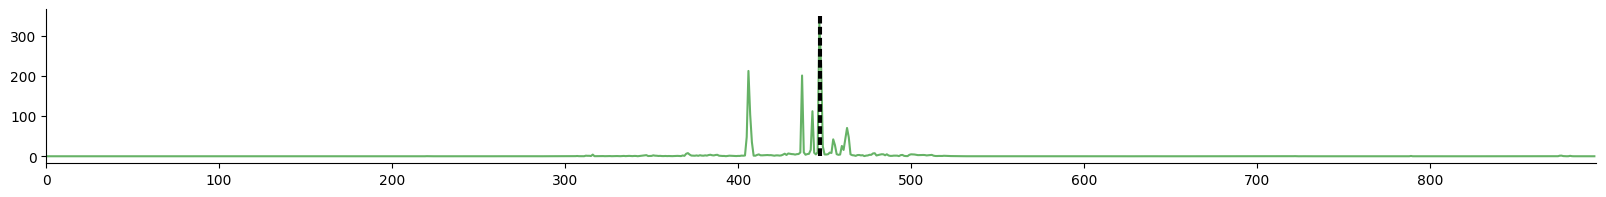

In [27]:
utils.plot_track([wt], color='green', zoom=[0, 896], marks=bins)


# Sufficiency test
In this example we will test the necessity of (5Kb) tiles in the context of an enhancing context sequence of GATA2 gene. 

To run the test we need:
- a loaded model
- onehot encoded sequence (WT) of the sequence
- TSS tile coordinates (or any other fixed tile coordinate that is always embedded in the shuffled backgrounds)
- a list of tile coordinates to test
- num_shuffle - number of shuffles to perform
- tile sequence (onehot) which can be extracted based on coordinates (if tile_seq is None)
- optionally, we can set mean=False to not average the shuffle results
- optionally, we can set return_seqs to True to return the shuffled sequeneces for future use


In [28]:
perturb_window = 5000
N_shuffles = 10
tss_tile, cre_tiles = utils.set_tile_range(model.seq_length, perturb_window)
cre_tiles = cre_tiles[19:20]
print(f'Enhancing tile at position {cre_tiles[0][0]} - {cre_tiles[0][1]}')
print(f'TSS tile at center position {tss_tile[0]} - {tss_tile[1]}')

Enhancing tile at position 100804 - 105804
TSS tile at center position 95804 - 100804


## Sufficiency of an enhancing tile of GATA2 gene TSS
As we can see, the GATA2 TSS activity is low on its own (control case of just TSS) compared to the high activity of the WT. 
However, when we embed the enhancing CRE together with the TSS the activity goes back up (not fully but to a much higher level than 
the control case).

In [40]:
_, pred_mut, pred_control, control_sequences = creme.sufficiency_test(model, wt_seq, tss_tile, cre_tiles, N_shuffles, mean=False, return_seqs=True)

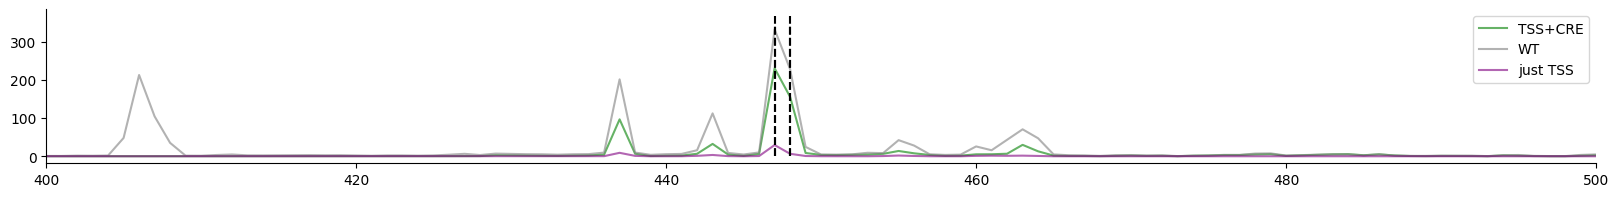

In [41]:
ax=utils.plot_track(pred_mut.mean(axis=1)[:,:,0], color='green', label='TSS+CRE')
utils.plot_track([wt], ax=ax, zoom=[400, 500], marks=[447,448], color='grey', label='WT')
utils.plot_track(pred_control.mean(axis=1)[:,:,0], color='purple', label='just TSS', ax=ax, zoom=[400, 500], marks=[447,448])
ax.legend();

# Fine-tile search
In this example we will use the same enhancing CRE of GATA2 from above. We will perform a fine-tile search to identify the smallest subset of tiles that explain the CRE effect of the this particular sufficient enhancer.  
The search output depends on these factors which need to be defined by the user depending on the specific aims:
1. scale: The test can run multiple stages of sequence pruning/randomization at different resolutions. This ensures that we can run a broad sweep at first to eliminate unnecessary sequences and then run a finer brush search for shorter sequences.
2. threshold: fraction explained/recovered below which we will stop the search or search stage. For instance, 0.9 means that once the current version of pruned sequence only recovers 80% of the original activity of the entire CRE tile the search will stop.
3. batch size: sometimes we will want to remove large scale windows, one at a time. At other times, we will want to prune smaller-scale windows but we will still want to speed up the process. This parameter determines how many sub-tiles we prune at a time. Note, setting window size to 500bp and batch size to 1 is not equivalent to setting window size to 50bp with batch size of 10 as these 10 sub-tiles can be discontinuous (occur in different parts of the sequence).

Note, we need to supply these as lists, e.g. scales=[500, 50], thresholds=[0.9, 0.7], N_batches=[1, 10] will run a fine-tile seach with 2 stages: (i) at 500bp, 1 tile at a time until fraction explained drops below 0.9, (ii) at 50bp, 10 tiles at a time until fraction explained drops below 0.7.
 
Once we set these custom parameters we can run the search by using the following:  

- a loaded model
- onehot encoded sequence (WT) of the sequence
- control sequences. These should contain the TSS embedded already.
- TSS activity when the whole CRE is embedded (with TSS) in background sequences
- tile start coordinate
- tile end coordinate
- scales (window sizes)
- thresholds (to stop the search)
- fraction of step size to move the sub-tile 
- batch sizes


In [67]:
track_index = [5111]
bins = [447, 448]
model = custom_model.Enformer(track_index=track_index, bin_index=bins)
target_df = pd.read_csv(f'../data/enformer_targets_human.txt', sep='\t')
cell_line_info = {i: [t, utils.clean_cell_name(target_df.iloc[t]['description'])] for i, t in
              enumerate(track_index)}

In [76]:
mut = pred_mut[:,:,bins,:].mean()
print(f'Mean CRE+TSS activity across bins 447 and 448 is {mut}')
scales = [500, 50]
thresholds = [0.9, 0.7]
frac=1
N_batches = [1, 10]


Mean CRE+TSS activity across bins 447 and 448 is 193.565185546875


## What smallest set of sub-tiles recovers 80% of the activity of the GATA2 enhancer?
GATA2 TSS activity is low on its own (control case of just TSS embedded in shuffled sequences) compared to the high activity of the WT. 
However, when we embed an enhancing CRE (identified previously) together with the TSS the activity goes back up (not fully but to a much higher level than the control case). But do we need the whole CRE for this effect?

In [78]:
%%time
optimization_results = creme.prune_sequence(model, 
                                          wt_seq, 
                                          control_sequences, 
                                          mut, 
                                          cre_tiles[0][0], 
                                          cre_tiles[0][1],
                                          scales, 
                                          thresholds, 
                                          frac,
                                          N_batches)

Tile size = 500, threshold = 0.9
Starting score: 1.0
10
Starting optimization...
score = 1.0
Number of tiles to test: 10
Number of tiles at the end of iteration: 10, score = 1.0085970163345337, bps = 4500.0
score = 1.0085970163345337
Number of tiles to test: 9
Number of tiles at the end of iteration: 9, score = 1.011488437652588, bps = 4000.0
score = 1.011488437652588
Number of tiles to test: 8
Number of tiles at the end of iteration: 8, score = 1.007453203201294, bps = 3500.0
score = 1.007453203201294
Number of tiles to test: 7
Number of tiles at the end of iteration: 7, score = 0.9873055219650269, bps = 3000.0
score = 0.9873055219650269
Number of tiles to test: 6
Number of tiles at the end of iteration: 6, score = 0.9530054926872253, bps = 2500.0
score = 0.9530054926872253
Number of tiles to test: 5
Number of tiles at the end of iteration: 5, score = 0.9063980579376221, bps = 2000.0
score = 0.9063980579376221
Number of tiles to test: 4
Number of tiles at the end of iteration: 4, scor

## Breakdown of results
The run above went through several iterations of pruning and testing if the threshold of acceptable fraction explained has been crossed. 
At iteration 20 (the second to last iteration) we get a score which is still above the threshold. The last iteration outputs a score lower than the threshold. To now re-create the final sequence of 500bp sub-tiles we can use the 'insert_coords' values in the results as shown below. 

In [92]:
final_sequences = control_sequences.copy()
for embed_start, embed_end in optimization_results[50]['insert_coords']:
    final_sequences[:, embed_start: embed_end, :] = wt_seq[embed_start: embed_end, :].copy()
final_prediction = model.predict(final_sequences)
final_prediction.mean() / mut

0.75893193